In [52]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
import os
import diptest
import fathon
from MFDFA import MFDFA
from MFDFA import fgn
from fathon import fathonUtils
from scipy.stats import skew, kurtosis
from hurst import compute_Hc, random_walk
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Read data files

In [4]:
folder_path = 'C:/1.1 Asia frequency data'
selected_files = ['ASI01_AUS01_regTS.csv', 'ASI01_SGP01_regTS.csv']

dataframes = []

for file_name in selected_files:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, sep=';')
    df.iloc[:, 1] = df.iloc[:, 1] / 1000 + 50
    dataframes.append(df)

    # Only select quality QI=0
flt_dataframes = []
for df in dataframes:
    flt_df = df[df['QI'] == 0].dropna()
    flt_dataframes.append(flt_df)
    
region_dict = {0: 'Australia', 1: 'Singapore'}

# Group the dataframes by region
region_groups = [df.groupby(lambda x: region_dict[i]) for i, df in enumerate(flt_dataframes)] 

colors=('#1b9e77','#e7298a')

### Plot the power gird frequency against time

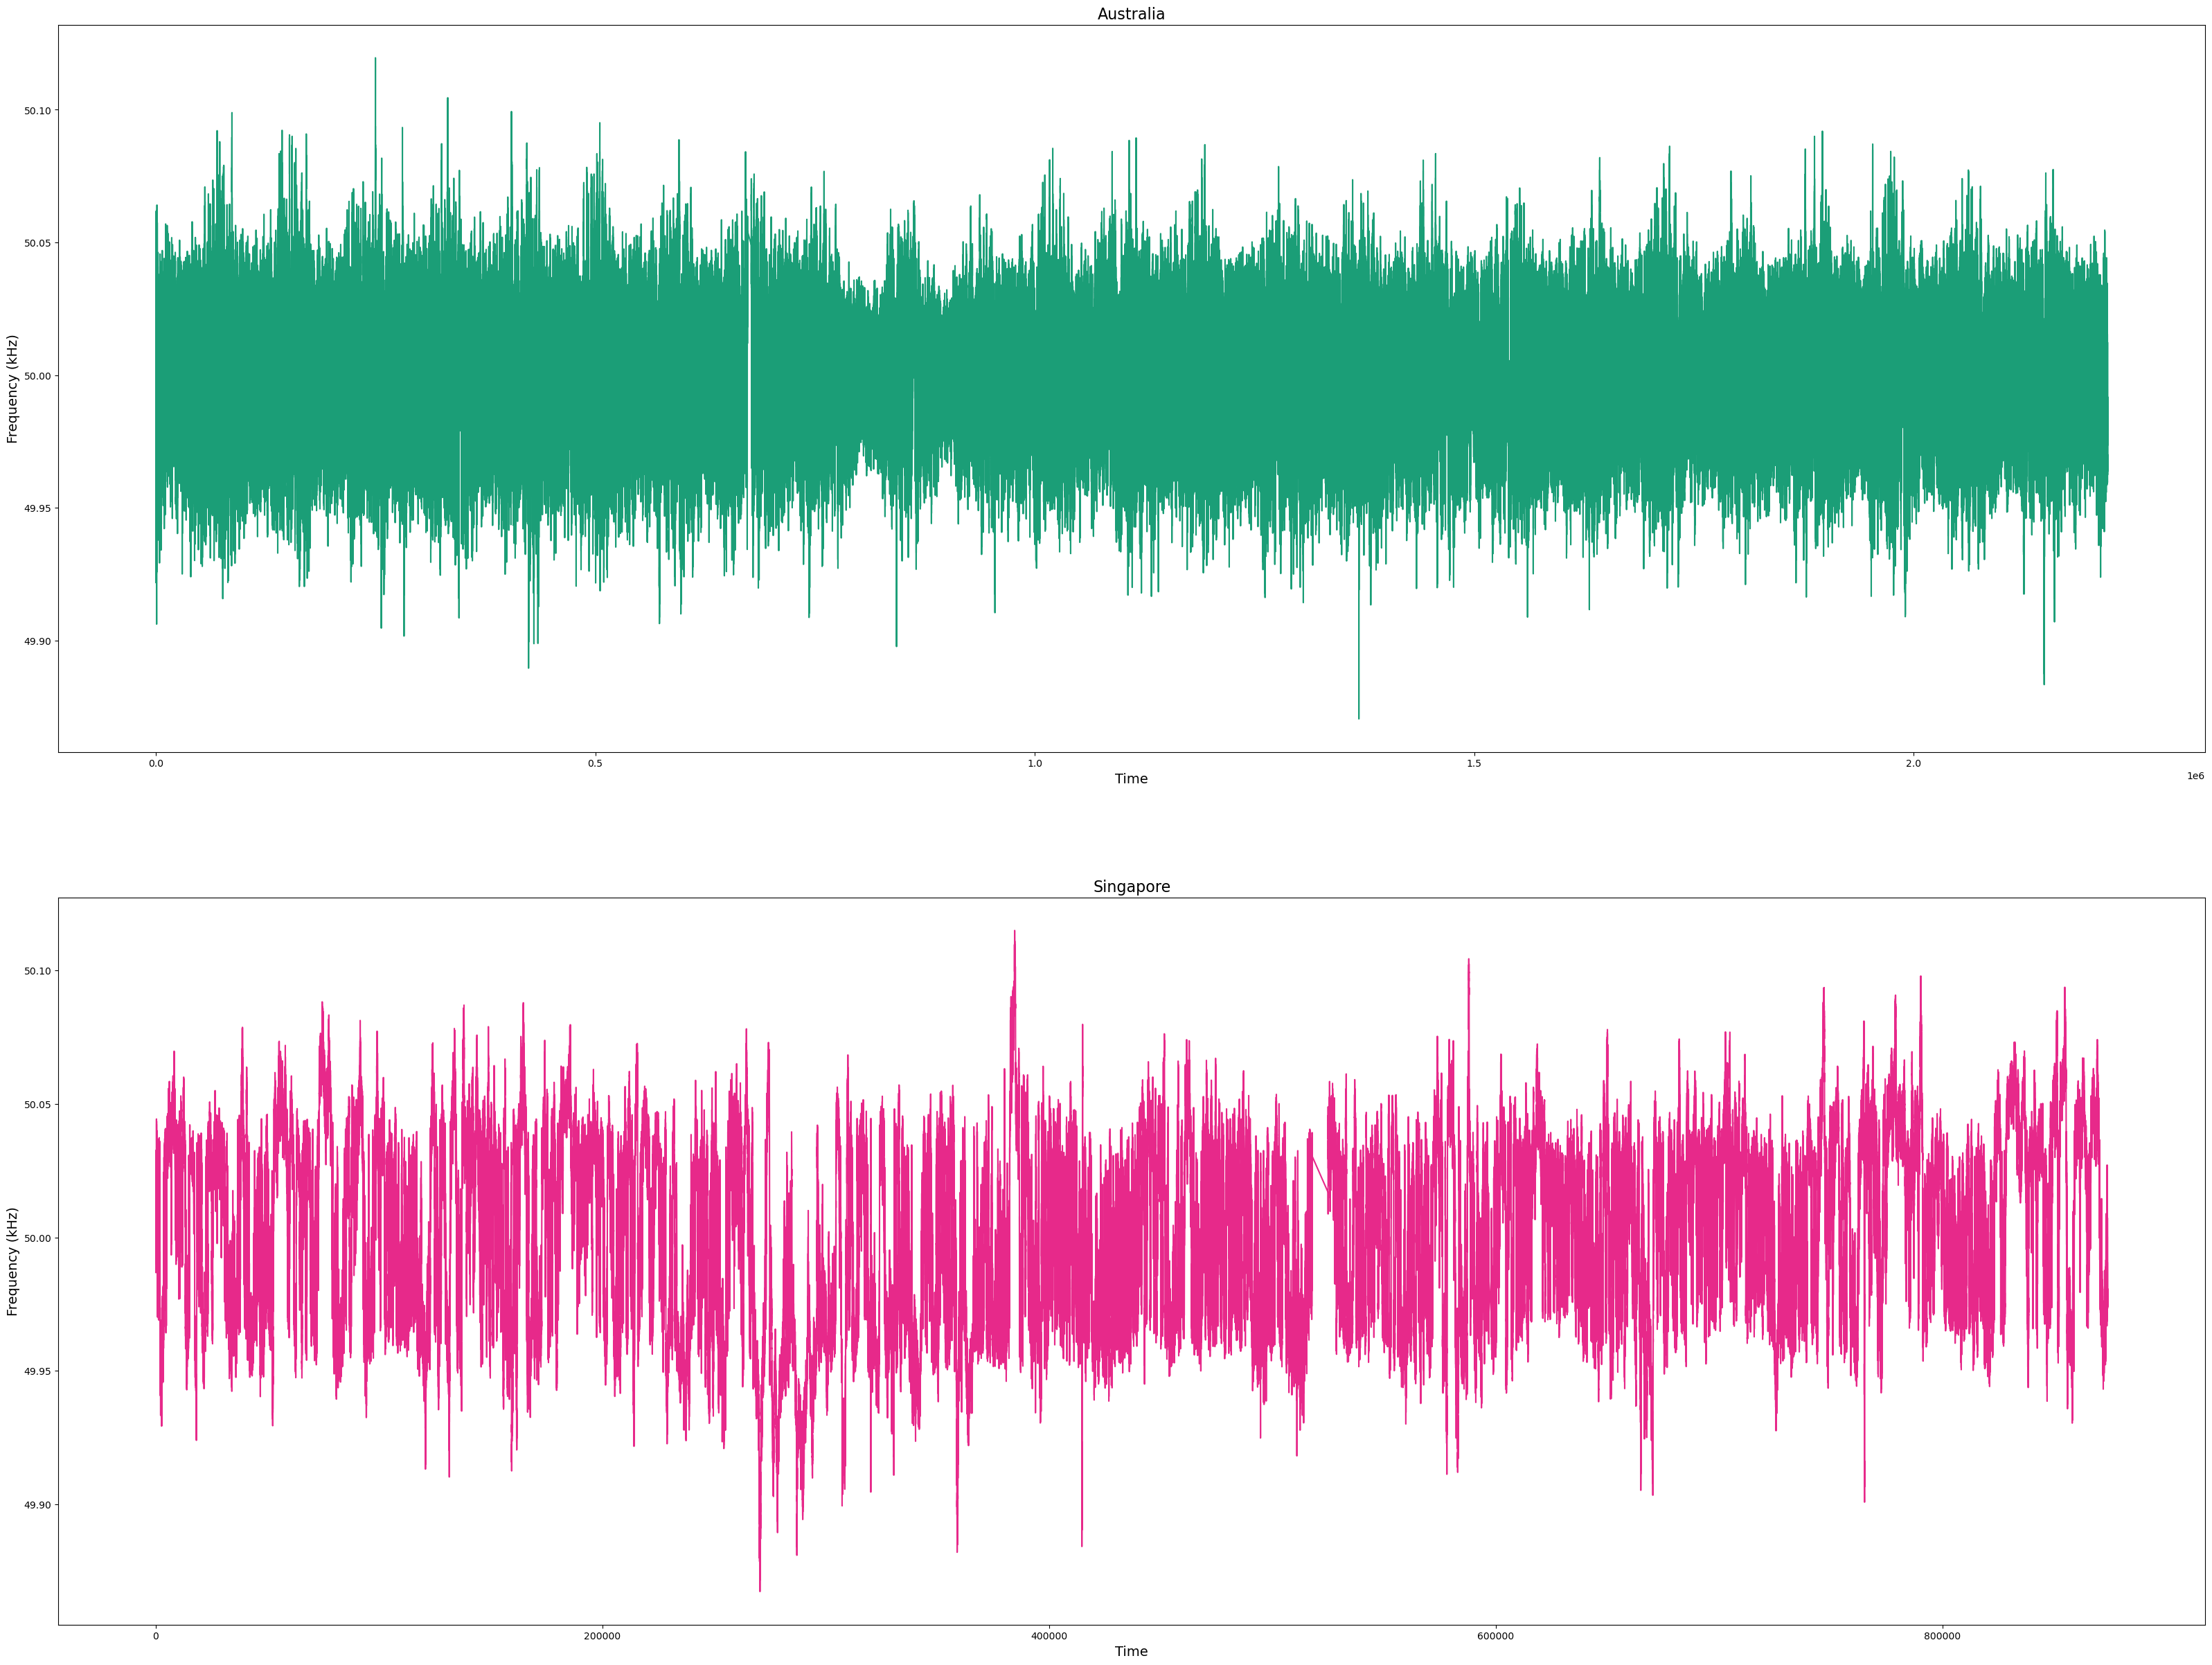

In [5]:
fig, axs = plt.subplots(nrows=len(flt_dataframes), figsize=(40,30))

for i, df in enumerate(flt_dataframes):
    axs[i].plot(df['f50'],color=colors[i])
    axs[i].set_title(region_dict[i], fontsize=16)
    axs[i].set_xlabel('Time', fontsize=14)
    axs[i].set_ylabel('Frequency (kHz)',fontsize=14)

#plt.tight_layout()
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

### Kernel density ploy

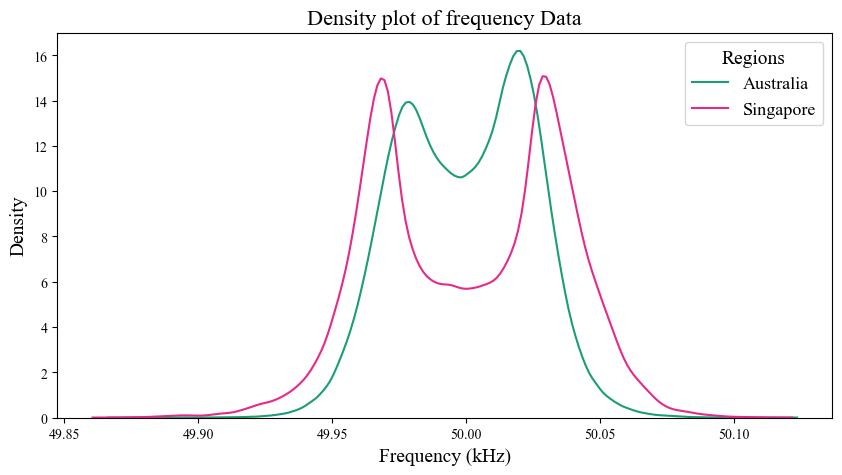

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

for i, df in enumerate(flt_dataframes):
    data = df.iloc[:,1]
    sns.kdeplot(data, color=colors[i], ax=ax, label=region_dict[i])
    ax.set_title('Density plot of frequency Data',fontsize=16)
    ax.set_xlabel('Frequency (kHz)',fontsize=14)
    ax.set_ylabel('Density',fontsize=14)

plt.legend(title = "Regions", title_fontsize=14, fontsize=13, loc='upper right')

plt.show()

### log kernel density plot

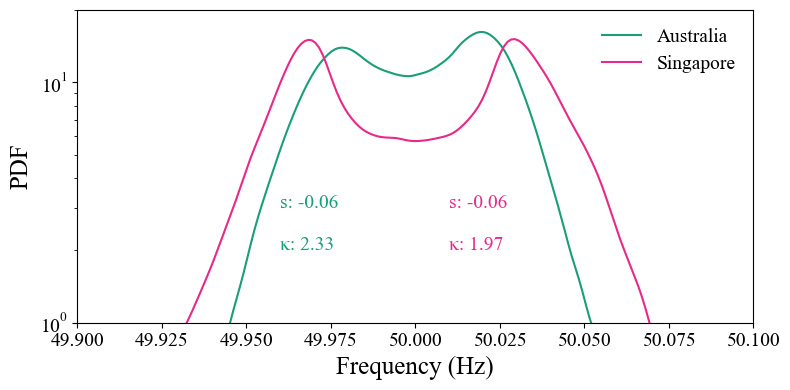

Region: Australia, Skewness: -0.06331057410019442, Kurtosis: 2.325879744238202
Region: Singapore, Skewness: -0.06274117921658388, Kurtosis: 1.9680568228425137


In [20]:
fig, ax = plt.subplots(figsize=(8, 4))

filtered_dfs = []
for i, df in enumerate(flt_dataframes):
    data = df[(df['f50'] >= 49.9) & (df['f50'] <= 50.1)]
    filtered_dfs.append(data)
    sns.kdeplot(data['f50'], color=colors[i], ax=ax, label=region_dict[i])
    
skewness = []
kurtosis = []

for df in filtered_dfs:
    skewness.append(df['f50'].skew())
    kurtosis.append(df['f50'].kurtosis() + 3)  

#ax.set_title('Asia-Australia', fontsize=12)
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('PDF', fontsize=18)
ax.set_yscale('log') 
ax.set_xlim([49.9, 50.1])
ax.set_ylim([1, 20])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

s = np.array(skewness)
k = np.array(kurtosis)


for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(49.96+i*0.05, 3, f's: {skew_val.item():.2f}', color=colors[i], fontsize=14)
    ax.text(49.96+i*0.05, 2, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=14)


plt.legend(fontsize=14, loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

# Print region name, skewness, and kurtosis values
for i, region in enumerate(region_dict):
    print(f"Region: {region_dict[i]}, Skewness: {skewness[i]}, Kurtosis: {kurtosis[i]}")


### Increment frequency

Region: Australia, Skewness: -0.06407959635258294, Kurtosis: 2.3355355227142716
Region: Singapore, Skewness: -0.08955554178022562, Kurtosis: 2.0715436486367884


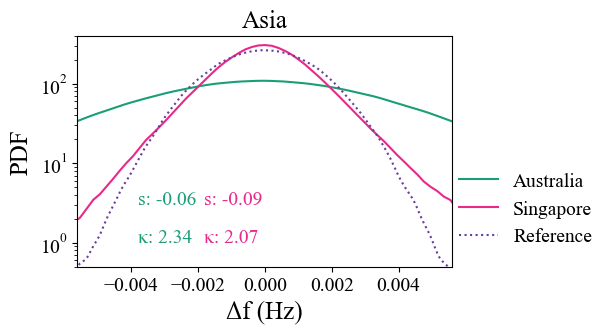

In [21]:
tau=1

from numpy import random
fig, ax = plt.subplots(figsize=(6,3))

filtered_dfs = []
for i, df in enumerate(flt_dataframes):
    df_copy = df.copy()
    df_copy['increment_freq'] = df_copy.iloc[:,1].diff(periods=tau)
    filtered_data = df_copy[(df_copy['increment_freq'] >= -0.02) & (df_copy['increment_freq'] <= 0.02)]
    filtered_dfs.append(filtered_data)
    
skewness = []
kurtosis = []

for df in filtered_dfs:
    skewness.append(df['f50'].skew())
    kurtosis.append(df['f50'].kurtosis()+3)

# Plot the filtered data inside the loop
for i, df in enumerate(filtered_dfs):
    sns.kdeplot(df['increment_freq'], color=colors[i], ax=ax, label=region_dict[i])
    
# Plot normal distribution curve
sns.kdeplot(random.normal(loc=0, scale=0.0015,size=100000), color= '#6a3d9a', ax=ax, label='Reference',linestyle=":")

ax.set_title('Asia',fontsize=18)
ax.set_xlabel('\u0394f (Hz)',fontsize=18)
ax.set_ylabel('PDF',fontsize=18)
ax.set_yscale('log') 

ax.set_xlim([-0.0056,0.0056])
ax.set_ylim([0.5,400])

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

# Add skewness and kurtosis annotations
s = skewness  
k = kurtosis 

for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(-0.0038+i*0.002, 3, f's: {skew_val.item():.2f}', color=colors[i], fontsize=14)
    ax.text(-0.0038+i*0.002, 1, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=14)

#plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(fontsize=14,bbox_to_anchor = (1.42, 0.25), loc='center right',frameon=False)

# Adjust subplot spacing
plt.subplots_adjust(right=0.75)

# Print region name, skewness, and kurtosis values
for i, region in enumerate(region_dict):
    print(f"Region: {region_dict[i]}, Skewness: {skewness[i]}, Kurtosis: {kurtosis[i]}")

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

### Stationary test

In [9]:
from statsmodels.tsa.stattools import kpss

for i, df in enumerate(flt_dataframes):
    data = df.iloc[:, 1].dropna().values
    result = kpss(data, regression="c", nlags="auto")
    test_statistic = result[0]
    p_value = result[1]

    if p_value < 0.05:
        print(f"Region {region_dict[i]}: p-value = {p_value:.4f} (Non-Stationary)")
    else:
        print(f"Region {region_dict[i]}: p-value = {p_value:.4f} (Stationary)")

Region Australia: p-value = 0.1000 (Stationary)
Region Singapore: p-value = 0.0100 (Non-Stationary)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Bimodality

In [29]:
dips=[]
for i, df in enumerate (flt_dataframes):
    dip,pval = diptest.diptest(df['f50'].astype(float))
    region=region_dict[i]
    dips.append((dip))
    print(f"Region: {region}, Dip Value: {dip:}")

Region: Australia, Dip Value: 0.009563206375083995
Region: Singapore, Dip Value: 0.04125250371863233


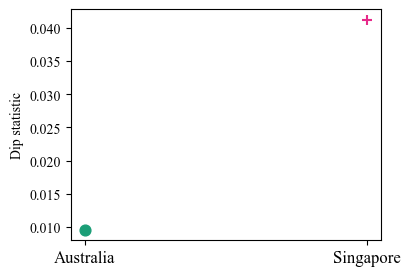

In [66]:
markers = ['o', '+']
colors=('#1b9e77','#e7298a')

# Set up the x-axis labels and positions
x_labels = list(region_dict.values())
x_pos = range(len(x_labels))

plt.figure(figsize=(4, 3))

# Plot the dip values
for i, dip in enumerate(dips):
    plt.scatter(x_pos[i], dips[i], marker=markers[i], color=colors[i], s=60, label=x_labels[i])

# Add the x-axis labels and title to the first plot
plt.xticks(x_pos, x_labels, fontsize=12)
plt.ylabel('Dip statistic')

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

### Linearity

In [40]:
def LTtest (data):
    # Compute Fourier transform 
    fft_0 = np.fft.fft(data)
    
    # Randomize phases of Fourier coefficients
    rand_phases = np.random.uniform(0, 2*np.pi, size=len(fft_0))
    surrogate = np.abs(fft_0) * np.exp(1j * rand_phases)
    
    # Compute inverse Fourier transform to obtain surrogate data
    surrogate = np.real(np.fft.ifft(surrogate))
    
    data = data[~np.isnan(data)]
    L = len(data)
    
    tau = np.arange(1, 82801,900 )
    #tau = np.arange(0, L//2, 3600)
    res_1 = np.zeros(len(tau))
    res_2 = np.zeros(len(tau))
    surr_1 = np.zeros(len(tau))
    surr_2 = np.zeros(len(tau))

    for i in range(len(tau)):
        x_t = data[0 :L-tau[i]]
        x_tau = data[tau[i]:L]
        y_t = surrogate[0:(L-tau[i])]
        y_tau = surrogate[(tau[i]):L]


        # First method LT1
        res_1[i] = np.mean(x_t**2 * x_tau)-np.mean(x_t * x_tau**2)
        surr_1[i] = np.mean(y_t**2 * y_tau)-np.mean(y_t *y_tau**2)

        # Second method LT2
        res_2[i] = np.mean((x_t-x_tau)**3)/np.mean((x_t-x_tau)**2)
        surr_2[i] = np.mean((y_t-y_tau)**3)/np.mean((y_t-y_tau)**2)
        
    # Calculate the rmse(LT1)
    #mse_lt1 = mean_squared_error(np.nan_to_num(res_1), np.nan_to_num(surr_1))
    #rmse_lt1 = np.sqrt(mse_lt1)
        
    # Calculate the rmse(LT2)
    mse_lt2 = mean_squared_error(np.nan_to_num(res_2), np.nan_to_num(surr_2))
    rmse_lt2 = np.sqrt(mse_lt2)
    
    return rmse_lt2

In [42]:
aus_rmse_lt2 = LTtest(flt_dataframes[0].f50.dropna().values)
sgp_rmse_lt2 = LTtest(flt_dataframes[1].f50.dropna().values)

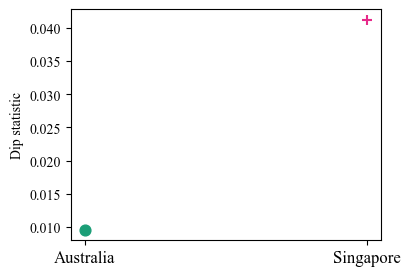

In [67]:
lt2=[aus_rmse_lt2, sgp_rmse_lt2]

markers = ['o', '+']


# Set up the x-axis labels and positions
x_labels = list(region_dict.values())
x_pos = range(len(x_labels))

plt.figure(figsize=(4, 3))

# Plot the dip values
for i, dip in enumerate(lt2):
    plt.scatter(x_pos[i], dips[i], marker=markers[i], color=colors[i], s=60, label=x_labels[i])

# Add the x-axis labels and title to the first plot
plt.xticks(x_pos, x_labels, fontsize=12)
plt.ylabel('Dip statistic')

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

### Chapman-Kolmogorov (CK) test

In [44]:
def CKtest (data, tau1, tau2, tau3, bins):
    
    data1 = data[tau1:-tau1] # x3
    data2 = data[tau2:-tau2] # x2
    data3 = data[tau3:-tau3] # x1
    
    # Find bin borders
    dx1 = np.ptp(data3/(bins-1))  # the difference between max and min of data
    dx2 = np.ptp(data2)/(bins-1)
    dx3 = np.ptp(data1)/(bins-1)
    x1 = np.arange(min(data3), np.max(data3)+dx1, dx1)
    x2 = np.arange(min(data2), np.max(data2)+dx2, dx2)
    x3 = np.arange(min(data1), np.max(data1)+dx3, dx3)
    dA = dx1 * dx2
    dV = dx1 * dx2 * dx3
    
    # Finding 2D conditional PDF P(Xt|X(t-1)) or P(x1|x2)
    X = np.column_stack((data3[:len(data3)], data2[:len(data3)]))
    count, edges = np.histogramdd(X, bins=[x1, x2])
    p_12_ref = count/(len(X)*dA)  # Joint PDF of x1, x2
    
    # Calculate p_2
    p_2 = np.zeros(bins-1) # 1d PDF P(x2)
    
    for j in range(bins-1):
        p_2[j] = np.sum(p_12_ref[j,:]) * dx1
        
        # Initialize p_1_2
        p_1_2 = np.zeros((bins-1, bins-1))
        
    # Calculate conditional PDF p_1_2
    for j in range(bins-1):
        if p_2[j] > 0:
            p_1_2[:,j] = p_12_ref[:,j] / p_2[j]

            
    # Set values less than 1e-3 to zero
    p_1_2[p_1_2 < 1e-3] = 0
    
    #Finding 3D conditional PDF P(X_t|X_(t-1),X_(t-2)) or P(x1|x2,x3)
    Y = np.zeros((len(data3), 3))
    Y[:, 0] = data3[:len(data3)]
    Y[:, 1] = data2[:len(data3)]
    Y[:, 2] = data1[:len(data3)]


    edges = (x1, x2, x3)
    count, edges = np.histogramdd(Y, bins=edges)
    mid = [0.5 * (edges[i][1:] + edges[i][:-1]) for i in range(3)]
    loc = np.array(np.unravel_index(np.arange(bins ** 3), (bins, bins, bins)), order='F').T

    # calculate the joint PDF of x2 and x3
    p_123_ref = count / (len(Y) * dV) # % Conditional PDF P(x1|x2,x3)
    p_23 = np.zeros((bins-1, bins-1))
    for i in range(bins-1):
        for j in range(bins-1):
            p_23[i, j] = np.sum(p_123_ref[i, j, :]) * dx1
            
    # calculate the conditional PDF of x1 given x2 and x3
    p_1_23 = np.zeros((bins-1, bins-1, bins-1))
    for i in range(bins-1):
        for j in range(bins-1):
            if p_23[i, j] > 0:
                p_1_23[:, i, j] = p_123_ref[:, i, j] / p_23[i, j]

    
    return x1, x2, p_1_2,p_1_23

In [46]:
# Define tau value sets
tau_sets = [
    [2, 4, 6],
    [5,10, 15],
    [20, 40, 60],
    [30, 60, 90],
    [50, 100, 150],
    [70, 140, 210],
    [90, 180, 270],
    [100, 200, 300],
    [200, 400, 600],
    [300, 600, 900],
    [400, 800, 1200],
    [500, 1000, 1500],
    [600, 1200, 1800],
    [700, 1400, 2100],
    [800, 1600, 2400],
    [900, 1800, 2700],
    [1000, 2000, 3000]
    
]

In [47]:
aus_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(flt_dataframes[0].f50.dropna().values, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    aus_distances.append(distance)

In [49]:
sgp_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(flt_dataframes[1].f50.dropna().values, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    sgp_distances.append(distance)

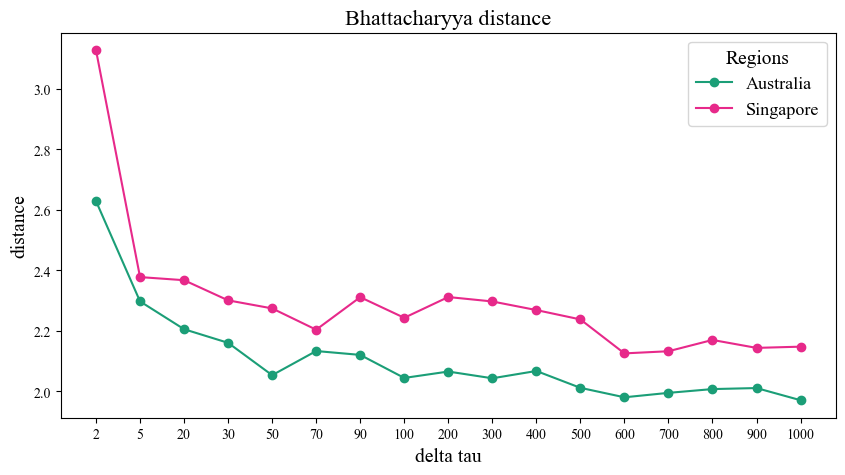

In [68]:
dis=[aus_distances,sgp_distances]


fig, ax = plt.subplots(figsize=(10,5))

for i, df in enumerate(dis):
    ax.plot(range(len(tau_sets)),df, 'o-',color=colors[i], label=region_dict[i])
    ax.set_title('Bhattacharyya distance',fontsize=16)
    ax.set_xlabel('delta tau',fontsize=14)
    ax.set_ylabel('distance',fontsize=14)

plt.xticks(range(len(tau_sets)),[2,5,20,30,50,70,90,100,200,300,400,500,600,700,800,900,1000]) 
#ax.set_xticklabels([0,2,5,20,30,50,70,90,100], fontsize=12)
plt.legend(title = "Regions", title_fontsize=14, fontsize=13, loc='upper right')

plt.show()

In [54]:
def generate_fractional_ou_process(H, t_final, delta_t, theta, sigma):
    # Time array
    time = np.linspace(0, t_final, int(t_final / delta_t) + 1)

    # Fractional Gaussian noise
    dB = (t_final ** H) * fgn(N=time.size, H=H)

    # Initialize the array
    y = np.zeros(time.size)
    y[0] = np.random.normal(size=1) / 10

    # Integrate the process
    for i in range(1, time.size):
        y[i] = y[i - 1] - theta * y[i - 1] * delta_t + sigma * dB[i]

    return time, y

In [55]:
fou2_distances=[]

time, process = generate_fractional_ou_process(H=0.2, t_final=500, delta_t=0.001, theta=0.3, sigma=0.1)

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(process, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    fou2_distances.append(distance)

In [61]:
fou5_distances=[]

time, process = generate_fractional_ou_process(H=0.5, t_final=700, delta_t=0.001, theta=0.3, sigma=0.1)

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(process, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    fou5_distances.append(distance)

In [60]:
fou8_distances=[]

time, process = generate_fractional_ou_process(H=0.8, t_final=900, delta_t=0.001, theta=0.3, sigma=0.1)

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = CKtest(process, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    fou8_distances.append(distance)

In [62]:
fou_dis=[fou2_distances,fou5_distances,fou8_distances]
fou_dict=('hurst 0.2','hurst 0.5','hurst 0.8')
fou_colors=('#7fc97f', '#beaed4','#fdc086')

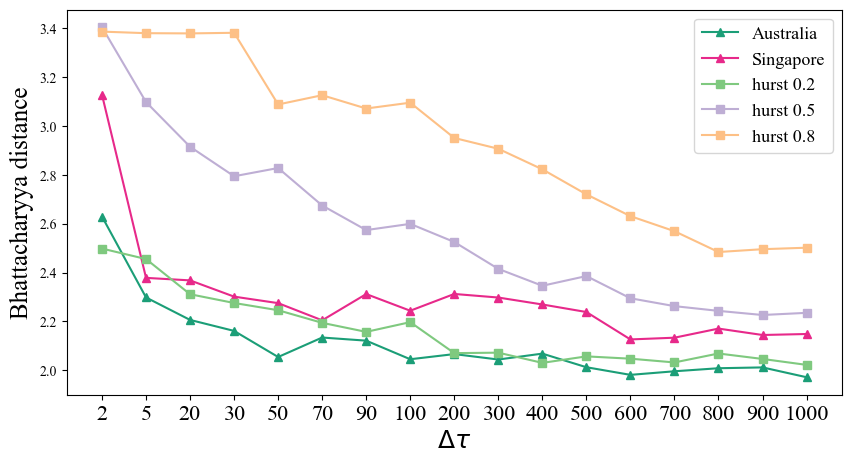

In [69]:
fig, ax = plt.subplots(figsize=(10,5))

# Plot Asia lines
for i, df in enumerate(dis):
    ax.plot(range(len(df)), df, '^-', color=colors[i], label=region_dict[i])

# Plot FBM lines
for i, df in enumerate(fou_dis):
    ax.plot(range(len(df)), df, 's-', color=fou_colors[i], label=fou_dict[i])

#ax.set_title('Bhattacharyya distance', fontsize=16)
ax.set_xlabel('$\u0394\u03C4$', fontsize=18)
ax.set_ylabel('Bhattacharyya distance', fontsize=18)
plt.xticks(range(len(tau_sets)), [2,5,20,30,50,70,90,100,200,300,400,500,600,700,800,900,1000], fontsize=16) 
plt.legend(fontsize=13, loc='upper right')

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

### Rescaled Range Analysis (R/S)

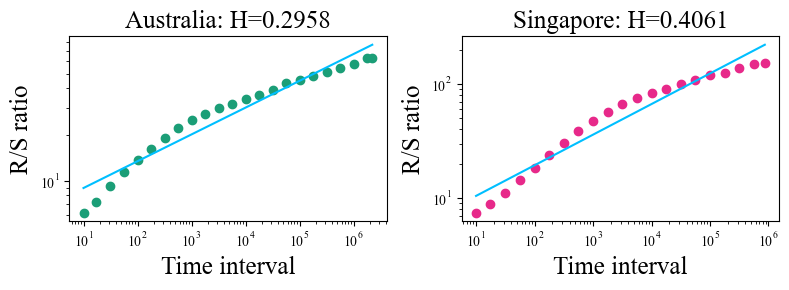

In [72]:
# Evaluate Hurst equation and plot for each region
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
for i, ax in enumerate(axes.flat):
    if i < len(region_groups):
        H, c, data = compute_Hc(flt_dataframes[i].f50.dropna().values, kind='price', simplified=True)
        ax.plot(data[0], c*data[0]**H, color="deepskyblue")
        ax.scatter(data[0], data[1], color=colors[i])
        np.polyfit(np.log(data[0]), np.log(data[1]), 1)
        H_new = np.polyfit(np.log(data[0])[:10], np.log(data[1])[:10], 1) [0]
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Time interval', fontsize=18)
        ax.set_ylabel('R/S ratio', fontsize=18)
        #ax.grid(True)
        ax.set_title('{}: H={:.4f}'.format(region_dict[i], H_new), fontsize=18) 
fig.tight_layout()

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

### Detrended Fluctuation Analysis (DFA)

Slope for Australia: [1.67346874]
Slope for Singapore: [1.8071113]


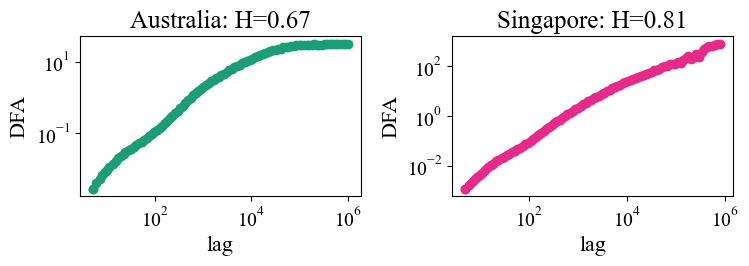

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.tight_layout(pad=4.0)  

lag = np.logspace(0.7, 6, 100).astype(int)
q = 2
order = 1

for i, df in enumerate(flt_dataframes):
    lag, dfa = MFDFA(df['f50'].dropna().values, lag=lag, q=q, order=order)
    ax = axs[i % 2]  # Determine the subplot position
    ax.loglog(lag, dfa, 'o', label='fOU: MFDFA q=2', color=colors[i])
    polyfit = np.polyfit(np.log(lag[:10]), np.log(dfa[:10]), 1)
    Hurst = polyfit[0] - 1
    ax.set_title(f"{region_dict[i]}: H={float(Hurst):.2f}", fontsize=18)
    ax.set_xlabel('lag', fontsize=16)
    ax.set_ylabel('DFA', fontsize=16)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    print(f"Slope for {region_dict[i]}: {polyfit[0]}")

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()